In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# this dataset is heavily skewed towards benign traffic.
df = pd.read_csv("data/preprocessed_CTU-IoT-Malware-Capture-21-1.csv")

In [5]:
df.head()

,id.resp_h,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,8,2,1,-0.031471,-0.120580,-0.091638,2,-0.028072,1,-0.031437,-0.033291,-0.032746,-0.035204,0
1,8,2,1,-0.031469,0.083804,0.114779,5,-0.028072,2,-0.025729,-0.022584,-0.021844,-0.016371,0
2,8,2,1,-0.025755,0.056852,-0.089369,2,-0.028072,1,-0.025729,-0.024210,-0.032746,-0.035204,0
3,8,2,1,-0.031469,0.083804,0.114779,5,-0.028072,2,-0.025729,-0.022584,-0.021844,-0.016371,0
4,8,2,1,-0.025717,0.144445,0.232731,5,-0.028072,2,-0.020022,-0.015129,-0.021844,-0.009663,0


# Train Test Split

In [49]:
# get a train test split which has most malware examples in the test set

malware = df[df['label'] == 1]
malware_test = malware.sample(frac=0.8, random_state=42)
malware_train = malware.drop(malware_test.index)

benign = df[df['label'] == 0]

benign_test = benign.sample(frac=0.8, random_state=42)
benign_train = benign.drop(benign_test.index)

train = pd.concat([malware_train, benign_train])
test = pd.concat([malware_test, benign_test])

X_train = train.drop(['label'], axis=1)
y_train = train['label']

X_test = test.drop(['label'], axis=1)
y_test = test['label']

# Shuffle the data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)


## Autoencoders for Anomaly Detection

Autoencoders are a type of neural network used for unsupervised learning and dimensionality reduction. They can also be highly effective for anomaly detection, especially when you have labeled data. Autoencoders work by learning to encode and decode data, which makes them well-suited for identifying anomalies based on the reconstruction error. Here's an expanded explanation of autoencoders for anomaly detection:

### Autoencoder Structure
An autoencoder consists of an encoder and a decoder, typically implemented as neural networks. The architecture can be divided into three main parts:

1. **Encoder**: The encoder network takes the input data and maps it to a lower-dimensional representation, often called the "encoding" or "latent space." The encoder learns to capture the most important features of the data in this lower-dimensional space.

2. **Latent Space**: The latent space is a compact representation of the input data, typically of much lower dimensionality. It contains essential features of the data.

3. **Decoder**: The decoder network takes the encoding from the latent space and reconstructs the input data as closely as possible. The goal is to minimize the reconstruction error, making the reconstructed data as similar to the input data as possible.

### Training an Autoencoder for Anomaly Detection
To use autoencoders for anomaly detection, you typically follow these steps:

1. **Training**: Train the autoencoder using only the normal data from your labeled dataset. The encoder learns to capture the characteristics of normal data while ignoring anomalies.

2. **Reconstruction Error**: Calculate the reconstruction error for each data point. This is the difference between the input data and the reconstructed data. A high reconstruction error indicates that the input data does not match the learned pattern of normal data.

3. **Threshold**: Set a threshold on the reconstruction error. Data points with reconstruction errors above this threshold are considered anomalies.

### Advantages of Autoencoders for Anomaly Detection
- **Unsupervised Learning**: Autoencoders do not require anomaly labels during training. They learn to represent normal data by capturing its essential features without any prior knowledge of anomalies.

- **Non-Linearity**: Autoencoders can capture complex, non-linear patterns in the data, making them suitable for a wide range of anomaly detection tasks.

- **Dimensionality Reduction**: Autoencoders inherently reduce the dimensionality of the data, which can help in capturing the most informative features and discarding noise.

- **Customizability**: Autoencoders can be customized in terms of architecture, activation functions, and loss functions to better match the data distribution and anomaly patterns.

- **Reconstruction Error**: The reconstruction error serves as a natural anomaly score. High reconstruction errors indicate that a data point doesn't fit the learned representation of normal data.



In [7]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [50]:
# build the model
from keras.models import Sequential
from keras.layers import Input, Dense

autoencoder = Sequential()
autoencoder.add(Input(shape=(X_train.shape[1],)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(32, activation='relu'))
autoencoder.add(Dense(16, activation='relu'))
autoencoder.add(Dense(32, activation='relu'))   
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(X_train.shape[1], activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='mse')


In [51]:
H = autoencoder.fit(X_train, X_train,
                epochs=15,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))


Epoch 1/15


21/21 [==============================] - 1s 10ms/step - loss: 37.2317 - val_loss: 36.5015
Epoch 2/15
21/21 [==============================] - 0s 5ms/step - loss: 36.3487 - val_loss: 36.0944
Epoch 3/15
21/21 [==============================] - 0s 5ms/step - loss: 36.1106 - val_loss: 35.9326
Epoch 4/15
21/21 [==============================] - 0s 5ms/step - loss: 36.0173 - val_loss: 35.9073
Epoch 5/15
21/21 [==============================] - 0s 5ms/step - loss: 35.9970 - val_loss: 35.9008
Epoch 6/15
21/21 [==============================] - 0s 5ms/step - loss: 35.9849 - val_loss: 35.8959
Epoch 7/15
21/21 [==============================] - 0s 5ms/step - loss: 35.9726 - val_loss: 35.8893
Epoch 8/15
21/21 [==============================] - 0s 5ms/step - loss: 35.9595 - val_loss: 35.8846
Epoch 9/15
21/21 [==============================] - 0s 5ms/step - loss: 35.9541 - val_loss: 35.8821
Epoch 10/15
21/21 [==============================] - 0s 5ms/step - loss: 35.9518 - val_loss: 35.8806
Epoch 11/

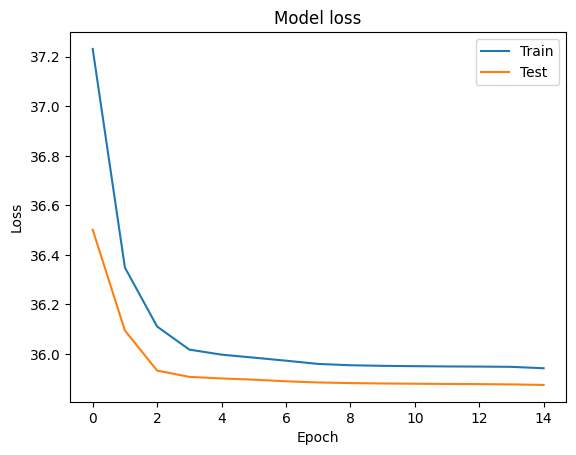

In [52]:
# Show model loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [53]:
# predictions
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

83/83 [==============================] - 0s 782us/step


In [54]:
error_df.head()

,reconstruction_error,true_class
2052,56.463967,1
2055,56.463762,1
20,56.463762,1
3146,802.443299,1
2046,56.463762,1


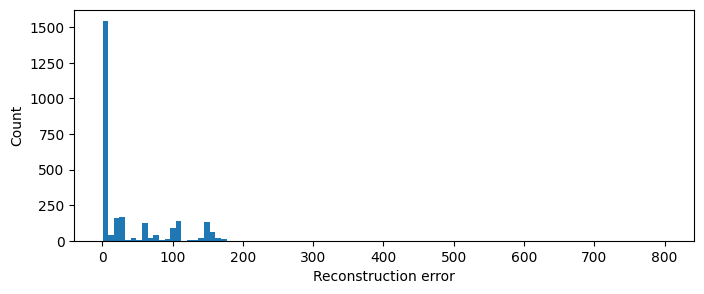

In [55]:
# show the distribution of the reconstruction error
plt.figure(figsize=(8, 3))
plt.hist(error_df.reconstruction_error.values, bins=100)
plt.xlabel('Reconstruction error')
plt.ylabel('Count')
plt.show()

As we can see, the dataset reconstruction error is heavily skewed towards low reconstruction errors, indicating that most of the data points are normal. We can use this to set a threshold for anomaly detection.

In [57]:
# Map the predictions to the labels
threshold = 0.1
error_df['pred_class'] = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

# get tp, tn, fp, fn
tp = error_df[(error_df['true_class'] == 1) & (error_df['pred_class'] == 1)].shape[0]
tn = error_df[(error_df['true_class'] == 0) & (error_df['pred_class'] == 0)].shape[0]
fp = error_df[(error_df['true_class'] == 0) & (error_df['pred_class'] == 1)].shape[0]
fn = error_df[(error_df['true_class'] == 1) & (error_df['pred_class'] == 0)].shape[0]

# get f1 score
from sklearn.metrics import f1_score
print("F1 score: ", f1_score(y_test, error_df['pred_class']))
print("True positives: ", tp)
print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)

F1 score:  0.008333333333333333
True positives:  11
True negatives:  0
False positives:  2618
False negatives:  0


Now, let's see how the model does when trained on the dataset which is more skewed towards anomalies.

In [58]:
df_big = pd.read_csv("data/preprocessed_CTU-IoT-Malware-Capture-48-1.csv")

X_train, X_test, y_train, y_test = train_test_split(df_big.drop(['label'], axis=1), df_big['label'], test_size=0.2, random_state=42)

In [60]:
autoencoder2 = Sequential()
autoencoder2.add(Input(shape=(X_train.shape[1],)))
autoencoder2.add(Dense(64, activation='relu'))
autoencoder2.add(Dense(32, activation='relu'))
autoencoder2.add(Dense(16, activation='relu'))
autoencoder2.add(Dense(32, activation='relu'))
autoencoder2.add(Dense(64, activation='relu'))
autoencoder2.add(Dense(X_train.shape[1], activation='sigmoid'))

autoencoder2.compile(optimizer='adam', loss='mse')


H2 = autoencoder2.fit(X_train, X_train,
                epochs=15,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))


Epoch 1/15
84859/84859 [==============================] - 123s 1ms/step - loss: 6.6519 - val_loss: 7.1531
Epoch 2/15
84859/84859 [==============================] - 122s 1ms/step - loss: 6.6505 - val_loss: 7.1531
Epoch 3/15
84859/84859 [==============================] - 122s 1ms/step - loss: 6.6508 - val_loss: 7.1603
Epoch 4/15
84859/84859 [==============================] - 122s 1ms/step - loss: 6.6579 - val_loss: 7.1603
Epoch 5/15
84859/84859 [==============================] - 122s 1ms/step - loss: 6.6579 - val_loss: 7.1603
Epoch 6/15
84859/84859 [==============================] - 121s 1ms/step - loss: 6.6579 - val_loss: 7.1603
Epoch 7/15
84859/84859 [==============================] - 123s 1ms/step - loss: 6.6579 - val_loss: 7.1603
Epoch 8/15
84859/84859 [==============================] - 122s 1ms/step - loss: 6.6579 - val_loss: 7.1603
Epoch 9/15
17702/84859 [=====>........................] - ETA: 1:24 - loss: 6.6957

In [ ]:
# Show model loss
plt.plot(H2.history['loss'])
plt.show()